# Project 1: Navigation
### Test 3 - DDQN model with Prioritized Experience Replay

<sub>Uirá Caiado. August 23, 2018<sub>

#### Abstract


_In this notebook, I will use the Unity ML-Agents environment to train a DDQN model with PER for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)._

## 1. What we are going to test

Quoting the seminal [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952) paper, from the Deep Mind team, experience replay lets online reinforcement learning agents remember and reuse experiences from the past. Bellow, I am going to test my implementation of the PER buffer in conjunction to Double DQN. Thus, let's begin by checking the environment where I am going to run these tests.

In [2]:
%load_ext version_information
%version_information numpy, unityagents, torch, matplotlib, pandas, gym

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.6 64bit [GCC 7.2.0]
IPython 6.5.0
OS Linux 4.4.0 1060 aws x86_64 with debian stretch sid
numpy 1.15.1
unityagents 0.4.0
torch 0.4.0
matplotlib 2.2.3
pandas 0.23.4
gym 0.10.5
Fri Aug 24 03:54:44 2018 UTC

Now, let's define some meta variables to use in this notebook

In [1]:
import os
fig_prefix = 'figures/2018-08-23-'
data_prefix = '../data/2018-08-23-'
s_currentpath = os.getcwd()

Also, let's import some of the necessary packages for this experiment.

In [ ]:
from unityagents import UnityEnvironment

In [1]:
import sys
import os
sys.path.append("../")  # include the root directory as the main
import eda
import pandas as pd
import numpy as np

## 2. Training the agent

The environment used for this project is the Udacity version of the Banana Collector environment, from [Unity](https://youtu.be/heVMs3t9qSk). The goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas. Bellow, we are going to start this environment.

In [5]:
env = UnityEnvironment(file_name="../Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Now, we are going to collect some basic information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)

And finally, we are going to train the model. We will consider that this environment is solved if the agent is able to receive an average reward (over 100 episodes) of at least +13.

In [8]:
%%time

import gym
import pickle
import random
import torch
import numpy as np
from collections import deque
from drlnd.dqn_agent import DQNAgent, DDQNAgent, DDQNPREAgent

n_episodes = 2000
eps_start = 1.
eps_end=0.01
eps_decay=0.995
max_t = 1000
s_model = 'ddqnpre'

agent = DDQNPREAgent(state_size=state_size, action_size=action_size, seed=0)

scores = []                        # list containing scores from each episode
scores_std = []                    # List containing the std dev of the last 100 episodes
scores_avg = []                    # List containing the mean of the last 100 episodes
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon

for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    for t in range(max_t):
        # action = np.random.randint(action_size)        # select an action
        action = agent.act(state, eps)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    scores_std.append(np.std(scores_window)) # save most recent std dev
    scores_avg.append(np.mean(scores_window)) # save most recent std dev
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=13.0:
        s_msg = '\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
        print(s_msg.format(i_episode, np.mean(scores_window)))
        torch.save(agent.qnet.state_dict(), '%scheckpoint_%s.pth' % (data_prefix, s_model))
        break
        
# save data to use latter
d_data = {'episodes': i_episode,
          'scores': scores,
          'scores_std': scores_std,
          'scores_avg': scores_avg,
          'scores_window': scores_window}
pickle.dump(d_data, open('%ssim-data-%s.data' % (data_prefix, s_model), 'wb'))

Episode 100	Average Score: 0.44
Episode 200	Average Score: 2.84
Episode 300	Average Score: 6.03
Episode 400	Average Score: 9.25
Episode 500	Average Score: 11.74
Episode 562	Average Score: 13.06
Environment solved in 562 episodes!	Average Score: 13.06
CPU times: user 16min 37s, sys: 20.7 s, total: 16min 58s
Wall time: 19min 18s


## 3. Results

The agent using Double DQN with Prioritized Experience Replay was able to solve the Banana Collector environment in 562 episodes of 1000 steps, each.

In [72]:
import pickle

d_data = pickle.load(open('../data/2018-08-23-sim-data-ddqnpre.data', 'rb'))
s_msg = 'Environment solved in {:d} episodes!\tAverage Score: {:.2f} +- {:.2f}'
print(s_msg.format(d_data['episodes'], np.mean(d_data['scores_window']), np.std(d_data['scores_window'])))

Environment solved in 562 episodes!	Average Score: 13.06 +- 3.47


Now, let's plot the rewards per episode. In the right panel, we will plot the rolling average score over 100 episodes $\pm$ its standard deviation, as well as the goal of this project (13+ on average over the last 100 episodes).

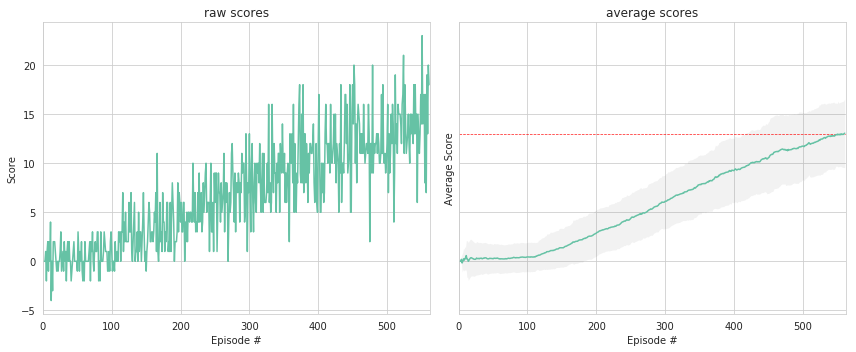

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

#recover data
na_raw = np.array(d_data['scores'])
na_mu = np.array(d_data['scores_avg'])
na_sigma = np.array(d_data['scores_std'])

# plot the scores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# plot the sores by episode
ax1.plot(np.arange(len(na_raw)), na_raw)
ax1.set_xlim(0, len(na_raw)+1)
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax1.set_title('raw scores')

# plot the average of these scores
ax2.axhline(y=13., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
ax2.plot(np.arange(len(na_mu)), na_mu)
ax2.fill_between(np.arange(len(na_mu)), na_mu+na_sigma, na_mu-na_sigma, facecolor='gray', alpha=0.1)
ax2.set_ylabel('Average Score')
ax2.set_xlabel('Episode #')
ax2.set_title('average scores')

f.tight_layout()

In [56]:
env.close()

## 4. Conclusion


The Double Deep Q-learning agent using Prioritized Experience Replay was able to solve the environment in 562 episodes and was the worst performance among all implementations. However, something that is worth noting that this implementation is seen to present the most smooth learning curve.

In [2]:
import pickle

d_ddqnper = pickle.load(open('../data/2018-08-23-sim-data-ddqnpre.data', 'rb'))
d_ddqn = pickle.load(open('../data/2018-08-24-sim-data-ddqn.data', 'rb'))
d_dqn = pickle.load(open('../data/2018-08-24-sim-data-dqn.data', 'rb'))

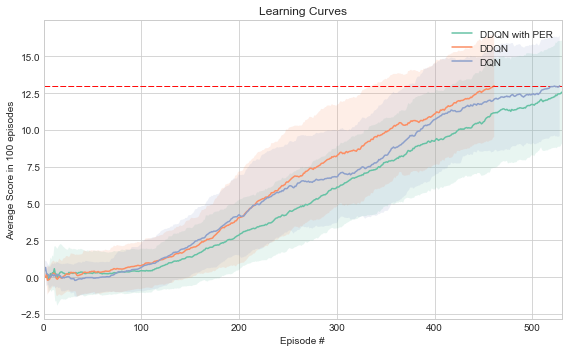

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

def recover_data(d_data):
    #recover data
    na_raw = np.array(d_data['scores'])
    na_mu = np.array(d_data['scores_avg'])
    na_sigma = np.array(d_data['scores_std'])
    return na_raw, na_mu, na_sigma

# plot the scores
f, ax2 = plt.subplots(1, 1, figsize=(8, 5), sharex=True, sharey=True)


for  s_model, d_data in zip(['DDQN with PER', 'DDQN', 'DQN'], [d_ddqnper, d_ddqn, d_dqn]):

    na_raw, na_mu, na_sigma = recover_data(d_data)
    ax2.set_xlim(0, len(na_raw)+1)
    # plot the average of these scores
    ax2.axhline(y=13., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
    ax2.plot(np.arange(len(na_mu)), na_mu, label=s_model)
    ax2.fill_between(np.arange(len(na_mu)), na_mu+na_sigma, na_mu-na_sigma, alpha=0.15)

ax2.legend()
ax2.set_title('Learning Curves')
ax2.set_ylabel('Average Score in 100 episodes')
ax2.set_xlabel('Episode #')
f.tight_layout()

Finally, let's compare the score distributions generated by the agents. I am going to perform the one-sided Welch's unequal variances t-test for the null hypothesis that the DDQN model has the expected score higher than the other agents on the final 100 episodes of each experiment. As the implementation of the t-test in the [Scipy](https://goo.gl/gs222c) assumes a two-sided t-test, to perform the one-sided test, we will divide the p-value by 2 to compare to a critical value of 0.05 and requires that the t-value is greater than zero.

In [3]:
import pandas as pd

def extract_info(s, d_data):
    return {'model': s,
            'episodes': d_data['episodes'],
            'mean_score': np.mean(d_data['scores_window']),
            'std_score': np.std(d_data['scores_window'])}

l_data = [extract_info(s, d) for s, d in zip(['DDQN with PER', 'DDQN', 'DQN'],
                                       [d_ddqnper, d_ddqn, d_dqn])]

df = pd.DataFrame(l_data)
df.index = df.model
df.drop('model', axis=1, inplace=True)
print(df.sort_values(by='episodes'))

               episodes  mean_score  std_score
model                                         
DDQN                462       13.01   3.479928
DQN                 529       13.01   3.421973
DDQN with PER       562       13.06   3.466468


In [ ]:
import scipy
#performs t-test
a = [float(pd.DataFrame(d_dqn['scores']).iloc[-1].values)] * 2
b = list(pd.DataFrame(d_rtn_test_1r['pnl']['test']).fillna(method='ffill').iloc[-1].values)
tval, p_value = scipy.stats.ttest_ind(a, b, equal_var=False)

In [12]:
import scipy
tval, p_value = scipy.stats.ttest_ind(d_ddqn['scores'], d_dqn['scores'], equal_var=False)
print("DDQN vs. DQN: t-value = {:0.6f}, p-value = {:0.8f}".format(tval, p_value))
tval, p_value = scipy.stats.ttest_ind(d_ddqn['scores'], d_ddqnper['scores'], equal_var=False)
print("DDQN vs. DDQNPRE: t-value = {:0.6f}, p-value = {:0.8f}".format(tval, p_value))

DDQN vs. DQN: t-value = -0.625024, p-value = 0.53210301
DDQN vs. DDQNPRE: t-value = 0.504778, p-value = 0.61382809


There was no significant difference between the performances of the agents.